In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '10.06_17.06_rescale'

In [4]:
# todo plot iters
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs):
    job_log = current_milestone / '{}.out'.format(job_id)

    try:
        exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(job_log)
        batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
        n_epochs = int(n_max_epochs)
        xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch

        if title:
            title = 'job #{}: "{}"'.format(job_id, title)
        else:
            title = ''

        plot_losses(
            ax, epochs[:n_epochs], xrange,
            title=title, xlabel='# batch iterations'
        )

        plot_metrics(
            ax.twinx(), epochs[:n_epochs], xrange,
            train_metric_ylim=metrics_ylim,
            eval_metric_ylim=metrics_ylim,
            metric_ylabel='average MPJPE relative to pelvis (mm)',
            with_SOTA=True
        )

        plot_lr(ax, lr_reductions, batch_amount_per_epoch)
        make_axis_great_again(ax, xlim=xrange, ylim=[0, 1], hide_y=True)
    except StopIteration:
        print('does {} even contain 1 complete epoch ??'.format(job_log))

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2], n_max_epochs=1e3):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row

    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim, n_max_epochs)
        
    plt.tight_layout()

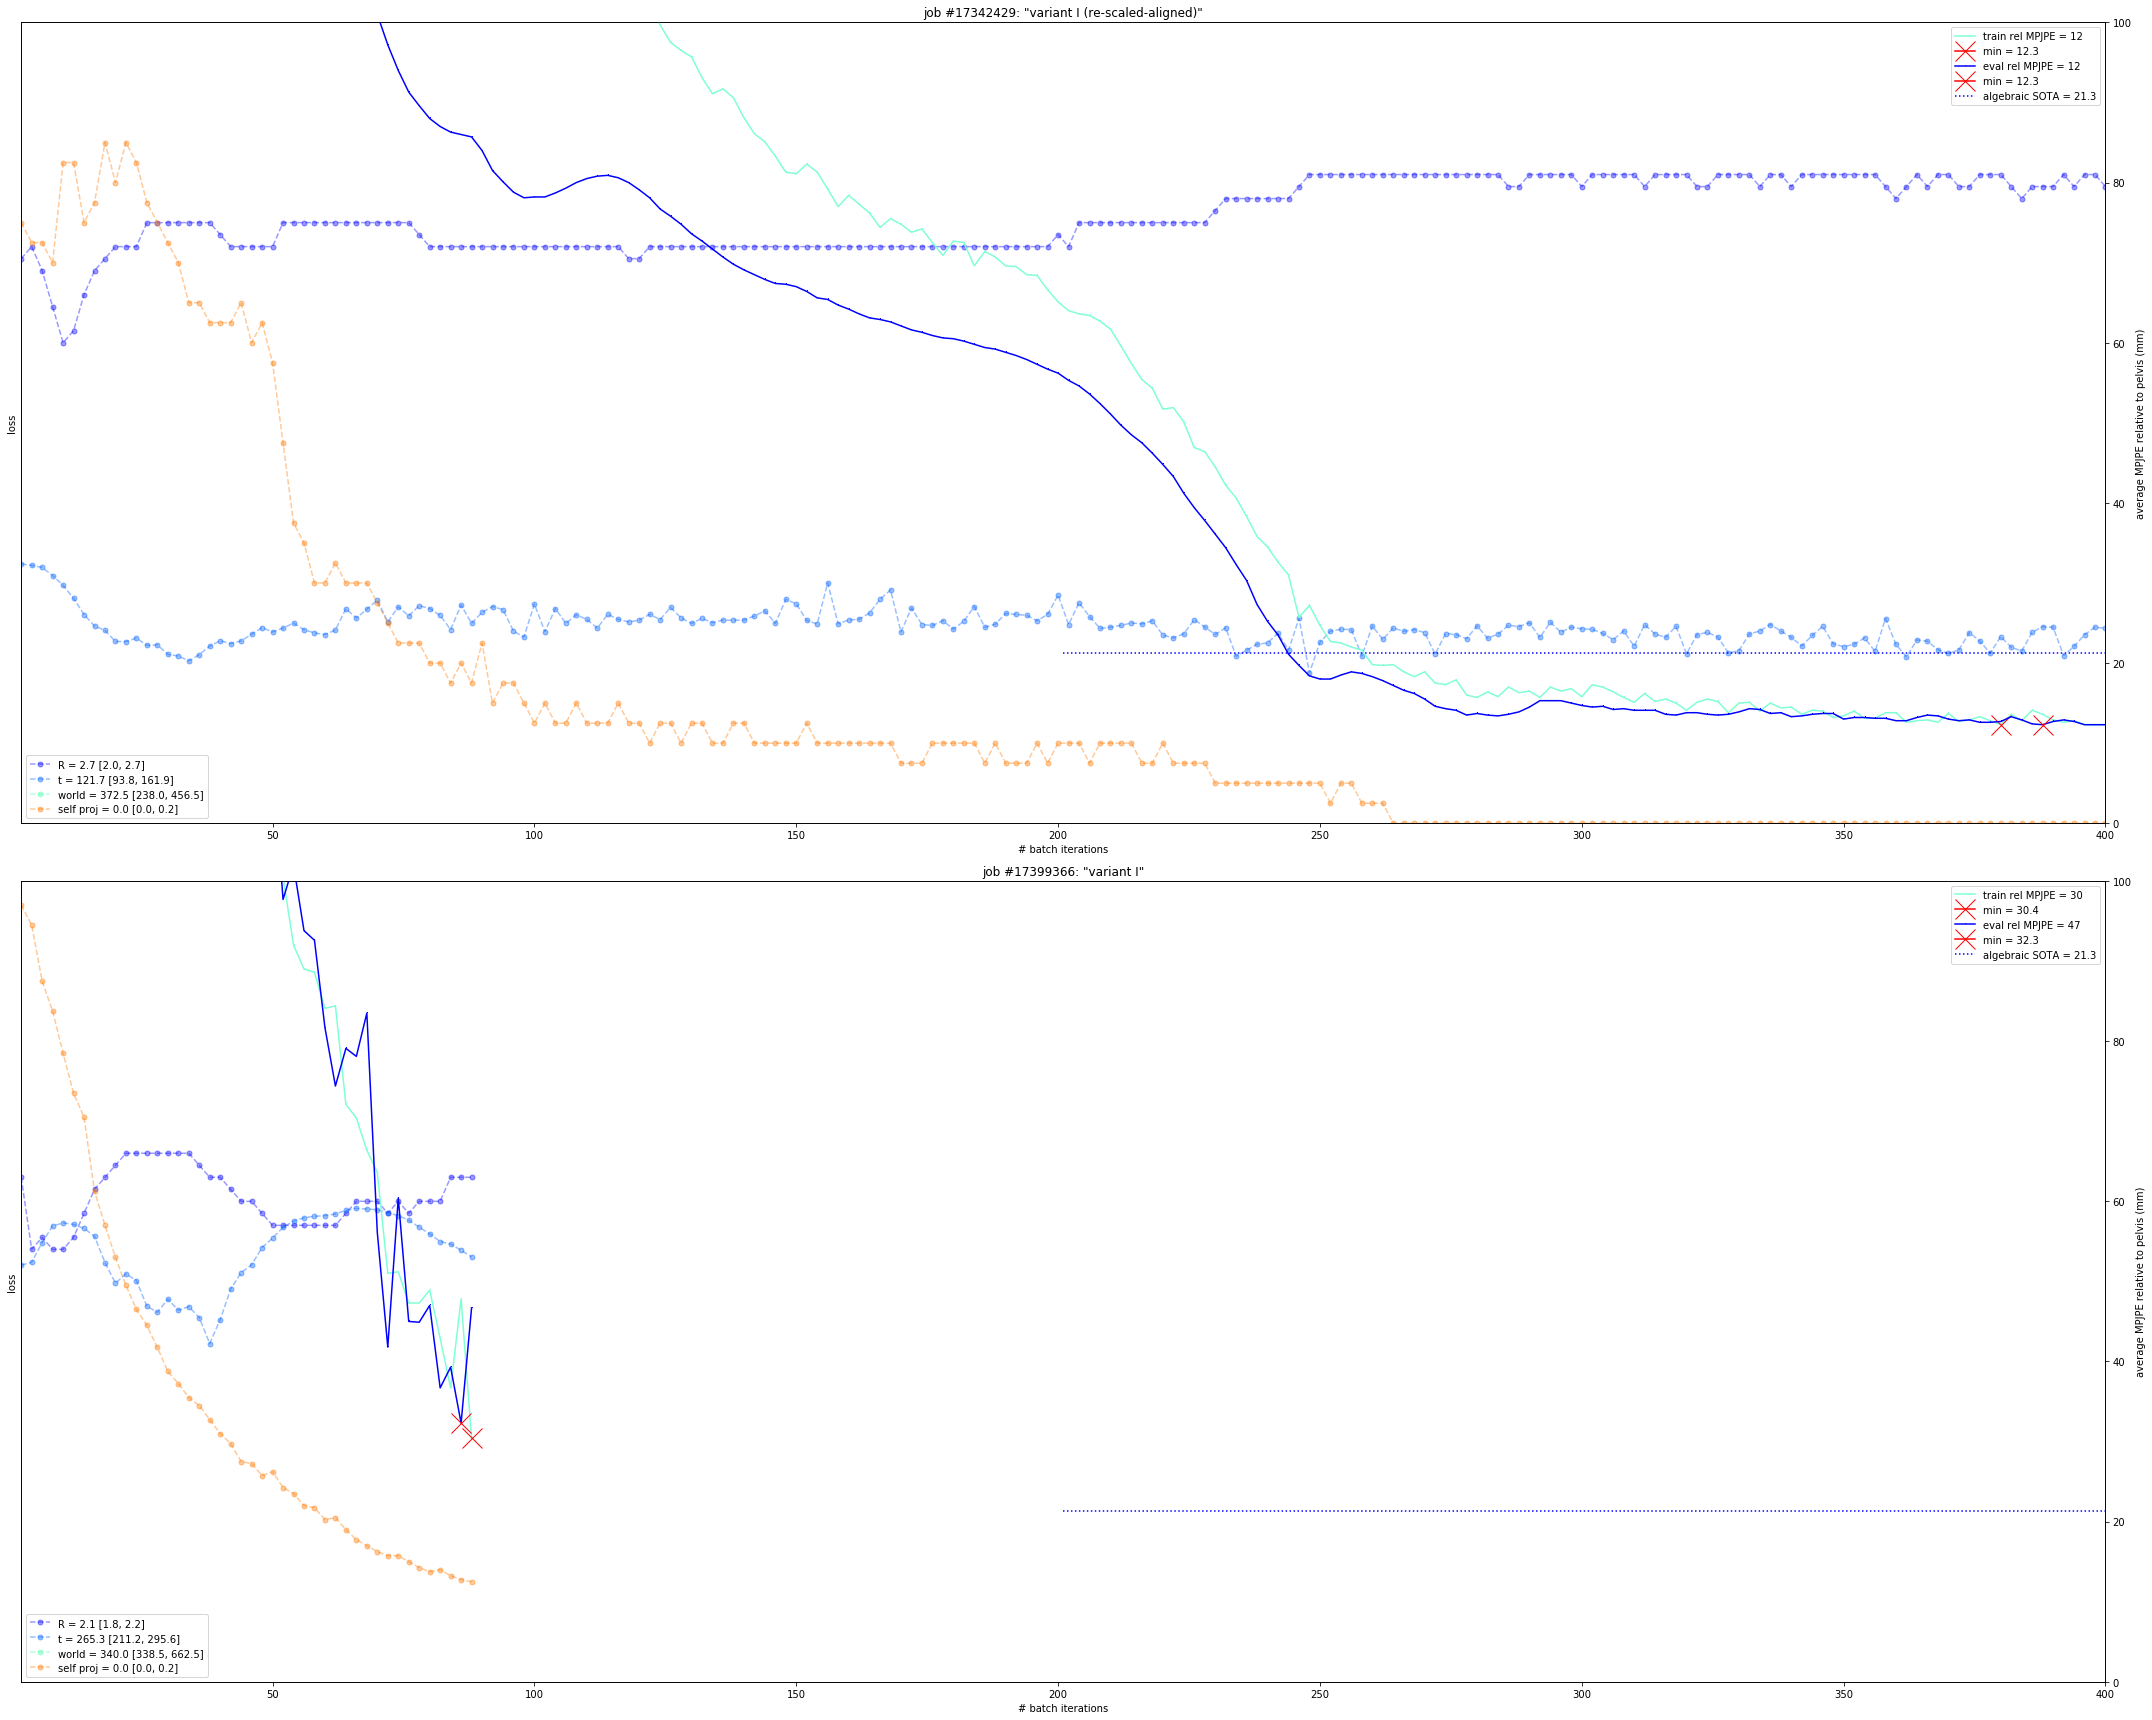

In [26]:
jobs = list(zip(*[   
    # pelvis NOT in origin, super R|t, super 3D KPs
    #('16884215', 'fixed'),
    
    # pelvis in origin, superv R|t, super 3D KPs
    #('16880504', 'variant I'),  # 17329211
    #('17204555', 'variant II'),  # predict master.ext, master2others
     
    # pelvis in origin, super 3D KPs
    #('16862312', '76d6959 supervising 3D'),  # here I was predicting directly the cam i -> j ...
    #('17037093', '8fcd56a'),  # ... here I predict ext for each cam. Others: 16932527
    #('17201912', 'variant II'),
        
    # pelvis in origin, super 1 3D KP
    #('17121242', 'just HEAD'),  # from 17121075-17113436
    #('17149053', 'just HEAD on 10% dataset'),  # from 17121767, evaluation job: 17151377
    
    # pelvis in origin, self-supervised
    #('17018882', 'a meno di rotazione/scaling ...'),  # variant I
    #('16983176', 'ScaleIndependentProjectionLoss (HuberLoss)'),  # 2 GT world points, using noisy KPs
    #('17295283', 'variant I (pre-trained with head -|)')
    ('17342429', 'variant I (re-scaled-aligned)'),  # 17352673
    #('17359339', '=17342429 but on 10% dataset, with `BerHuLoss(threshold=0.25)`'),
    #('', 'variant II (re-scaled-aligned)'),
    
    # pelvis in origin, self-supervised, many cams (re-aligned)
    ('17399366', 'variant I'),
    #('17394960', 'variant I (supervised)')
    
    # pelvis in origin, self-supervised, 1 GT cam
    #('', 'variant I'),
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 100], n_max_epochs=200)